In [1]:
!pip install jsonlines
import os
import json
import jsonlines
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [0]:
import torch
import torch.nn as nn

In [3]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

datasets,vocab = load_wikitext()

--2019-10-01 19:22:29--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-01 19:22:29--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-01 19:22:30--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
        # include test
        for line in tqdm(datasets['test']):
            for w in line:
                self.add_token(w)
        
        
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [6]:
wikitext_dict = Dictionary(datasets, include_valid=True)
# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 9708/9708 [00:13<00:00, 727.97it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> (hidden,hidden*num_layers)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [15]:
model_dict_RNN = torch.load('RNN_model.pt')
options_RNN = model_dict_RNN['options']
model_RNN = RNNLanguageModel(options_RNN).to(current_device)
model_RNN.load_state_dict(torch.load("RNN_checkpoint.pt"))

<All keys matched successfully>

In [16]:
model_RNN

RNNLanguageModel(
  (lookup): Embedding(33186, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33186, bias=True)
)

In [0]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> output, (h_n,c_n)     (hidden,hidden*num_layers)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [18]:
model_dict_LSTM1 = torch.load('LSTM_model.pt')    
options_LSTM1 = model_dict_LSTM1['options']
model_LSTM1 = LSTMLanguageModel(options_LSTM1).to(current_device)
model_LSTM1.load_state_dict(torch.load("LSTM_checkpoint.pt"))

<All keys matched successfully>

In [19]:
model_LSTM1

LSTMLanguageModel(
  (lookup): Embedding(33186, 256, padding_idx=2)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33186, bias=True)
)

In [22]:
model_dict_LSTM2 = torch.load('LSTM_bigger_model.pt')    
options_LSTM2 = model_dict_LSTM2['options']
model_LSTM2 = LSTMLanguageModel(options_LSTM2).to(current_device)
model_LSTM2.load_state_dict(torch.load("LSTM_bigger_checkpoint.pt"))

<All keys matched successfully>

In [23]:
model_LSTM2

LSTMLanguageModel(
  (lookup): Embedding(33186, 512, padding_idx=2)
  (lstm): LSTM(512, 1024, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=1024, out_features=33186, bias=True)
)

In [20]:
model_dict_LSTM3 = torch.load('LSTM_model3.pt')    
options_LSTM3 = model_dict_LSTM3['options']
model_LSTM3 = LSTMLanguageModel(options_LSTM3).to(current_device)
model_LSTM3.load_state_dict(torch.load("LSTM_checkpoint3.pt"))

<All keys matched successfully>

In [21]:
model_LSTM3

LSTMLanguageModel(
  (lookup): Embedding(33186, 256, padding_idx=2)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=256, out_features=33186, bias=True)
)

# 2.1: LSTM vs. RNN

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plot_cache_RNN = model_dict_RNN['loss_cache']
plot_cache_LSTM1 = model_dict_LSTM1['loss_cache']
plot_cache_LSTM2 = model_dict_LSTM2['loss_cache']
plot_cache_LSTM3 = model_dict_LSTM3['loss_cache']

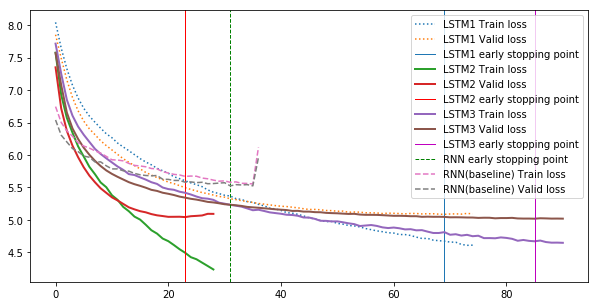

In [26]:
epochs_RNN = np.array(list(range(len(plot_cache_RNN))))
epochs_LSTM1 = np.array(list(range(len(plot_cache_LSTM1))))
epochs_LSTM2 = np.array(list(range(len(plot_cache_LSTM2))))
epochs_LSTM3 = np.array(list(range(len(plot_cache_LSTM3))))
plt.figure(figsize=(10,5))


plt.plot(epochs_LSTM1, [i[0] for i in plot_cache_LSTM1], label='LSTM1 Train loss',linestyle='dotted')
plt.plot(epochs_LSTM1, [i[1] for i in plot_cache_LSTM1], label='LSTM1 Valid loss',linestyle='dotted')
plt.axvline(x=epochs_LSTM1[-6],label="LSTM1 early stopping point",linewidth=1)


plt.plot(epochs_LSTM2, [i[0] for i in plot_cache_LSTM2], label='LSTM2 Train loss',linewidth=2)
plt.plot(epochs_LSTM2, [i[1] for i in plot_cache_LSTM2], label='LSTM2 Valid loss',linewidth=2)
plt.axvline(x=epochs_LSTM2[-6],label="LSTM2 early stopping point",linewidth=1,color="r")

plt.plot(epochs_LSTM3, [i[0] for i in plot_cache_LSTM3], label='LSTM3 Train loss',linewidth=2)
plt.plot(epochs_LSTM3, [i[1] for i in plot_cache_LSTM3], label='LSTM3 Valid loss',linewidth=2)
plt.axvline(x=epochs_LSTM3[-6],label="LSTM3 early stopping point",linewidth=1,color="m")


plt.axvline(x=epochs_RNN[-6],label="RNN early stopping point",color="g",linestyle="--",linewidth=1)
plt.plot(epochs_RNN, [i[0] for i in plot_cache_RNN], label='RNN(baseline) Train loss',linestyle="--")
plt.plot(epochs_RNN, [i[1] for i in plot_cache_RNN], label='RNN(baseline) Valid loss',linestyle="--")


plt.legend()
plt.show()

In [28]:
print("Perplexity for RNN baseline is",[2**(i[1]/np.log(2)) for i in plot_cache_RNN][-6])
print("Perplexity for LSTM1 is",[2**(i[1]/np.log(2)) for i in plot_cache_LSTM1][-6])
print("Perplexity for LSTM2 is",[2**(i[1]/np.log(2)) for i in plot_cache_LSTM2][-6])
print("Perplexity for LSTM3 is",[2**(i[1]/np.log(2)) for i in plot_cache_LSTM3][-6])

Perplexity for RNN baseline is 250.64625058797918
Perplexity for LSTM1 is 161.6276941957559
Perplexity for LSTM2 is 154.94733051084611
Perplexity for LSTM3 is 151.1431343689896


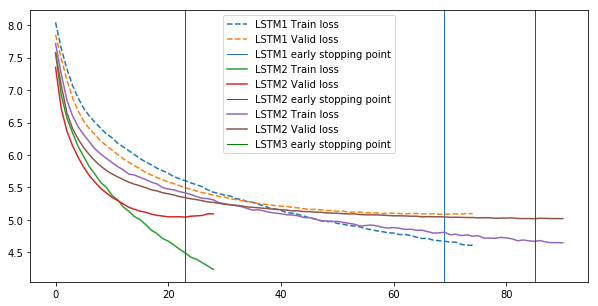

In [30]:
epochs_LSTM1 = np.array(list(range(len(plot_cache_LSTM1))))
epochs_LSTM2 = np.array(list(range(len(plot_cache_LSTM2))))
epochs_LSTM3 = np.array(list(range(len(plot_cache_LSTM3))))
plt.figure(figsize=(10,5))


plt.plot(epochs_LSTM1, [i[0] for i in plot_cache_LSTM1], label='LSTM1 Train loss',linestyle="--")
plt.plot(epochs_LSTM1, [i[1] for i in plot_cache_LSTM1], label='LSTM1 Valid loss',linestyle="--")
plt.axvline(x=epochs_LSTM1[-6],label="LSTM1 early stopping point",linewidth=1)


plt.plot(epochs_LSTM2, [i[0] for i in plot_cache_LSTM2], label='LSTM2 Train loss')
plt.plot(epochs_LSTM2, [i[1] for i in plot_cache_LSTM2], label='LSTM2 Valid loss')
plt.axvline(x=epochs_LSTM2[-6],label="LSTM2 early stopping point",linewidth=1,color="r")

plt.plot(epochs_LSTM3, [i[0] for i in plot_cache_LSTM3], label='LSTM2 Train loss')
plt.plot(epochs_LSTM3, [i[1] for i in plot_cache_LSTM3], label='LSTM2 Valid loss')
plt.axvline(x=epochs_LSTM3[-6],label="LSTM3 early stopping point",linewidth=1,color="g")

plt.legend()
plt.show()

Discussion of result: as we can see, the baseline RNN model has the worst perplexity, which can be due to vanishing/exploding gradient problems that RNN is very vulnerable to. On the other hand, our largest LSTM model took the least epochs to reach to approxmiately 155 perplexity, though our smaller model reached to a lower perplexity, of 151, after 80+ epochs.

# 2.2: Learned embeddings

## Lookup

In [31]:
!pip install umap-learn

In [32]:
weight_matrix_lookup = model_LSTM3.lookup.weight

word_list = ["Japan","man","speak","basketball","happy"]
word_list_id = [wikitext_dict.get_id(word) for word in word_list]
word_list_id

[18, 3540, 7693, 9981, 4233]

In [33]:
def cosine_similarity(x1, x2, dim=0, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

cosine_similarity(torch.rand(3,1),torch.rand(3,1))

tensor(0.9238)

In [0]:
closest_dict_lookup = {}
farthest_dict_lookup = {}

lsts_lookup = {}

for word in word_list:
    lst_lookup = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix_lookup.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix_lookup[word_id],weight_matrix_lookup[i])
            lst_lookup.append((cos_sim.item(),i))
        lst_lookup = sorted(lst_lookup, key=lambda x: x[0], reverse=True)
        lsts_lookup[word] = lst_lookup
        closest_dict_lookup[word] = [l[1] for l in lst_lookup[:10]]
        farthest_dict_lookup[word] = [l[1] for l in lst_lookup[-10:]]

In [35]:
for word in word_list:
    print("the closest 10 for", word, ":", [wikitext_dict.get_token(i) for i in closest_dict_lookup[word]])
    print("the farthest 10 for", word, ":",[wikitext_dict.get_token(i) for i in farthest_dict_lookup[word]])
    print("highest cosine similarity:", lsts_lookup[word][0][0], "word:", wikitext_dict.get_token(lsts_lookup[word][0][1]))
    print("lowest cosine similarity:", lsts_lookup[word][-1][0], "word:", wikitext_dict.get_token(lsts_lookup[word][-1][1]))
    print("\n\n")

the closest 10 for Japan : ['boarding', 'ruinous', 'Selenites', 'masked', 'drawbacks', 'ourebi', '322', 'Waterfall', 'Management', 'WWII']
the farthest 10 for Japan : ['modeled', 'Radford', 'TOT', 'Kelly', 'hence', 'Gift', 'fixed', 'Sudan', 'northwest', 'Rihanna']
highest cosine similarity: 0.240296870470047 word: boarding
lowest cosine similarity: -0.2686678171157837 word: Rihanna



the closest 10 for man : ['Ouranosaurus', 'plectrum', 'is', 'swing', 'astray', 'powerfully', 'holder', 'harvest', 'culminated', 'Berio']
the farthest 10 for man : ['Die', 'miner', 'rub', 'aiding', 'freely', 'mills', 'Township', 'campaigns', 'Wanna', 'pond']
highest cosine similarity: 0.23912107944488525 word: Ouranosaurus
lowest cosine similarity: -0.2459438443183899 word: pond



the closest 10 for speak : ['conscious', 'displayed', 'arguably', 'Crusade', 'Beach', 'income', 'biographers', 'Tel', 'rookie', 'Singaporean']
the farthest 10 for speak : ['16', 'ticking', 'infatuation', 'dismemberment', 'Additi

In [36]:
%pylab inline 
import umap

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(15,15))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [0]:
total_idx_lookup = [closest_dict_lookup[w] for w in word_list] + [farthest_dict_lookup[w] for w in word_list]
import itertools
total_idx_lookup = list(itertools.chain(*total_idx_lookup))
total_words_lookup = word_list + [wikitext_dict.get_token(i) for i in total_idx_lookup]
total_idx_lookup = [wikitext_dict.get_id(w) for w in word_list] + total_idx_lookup

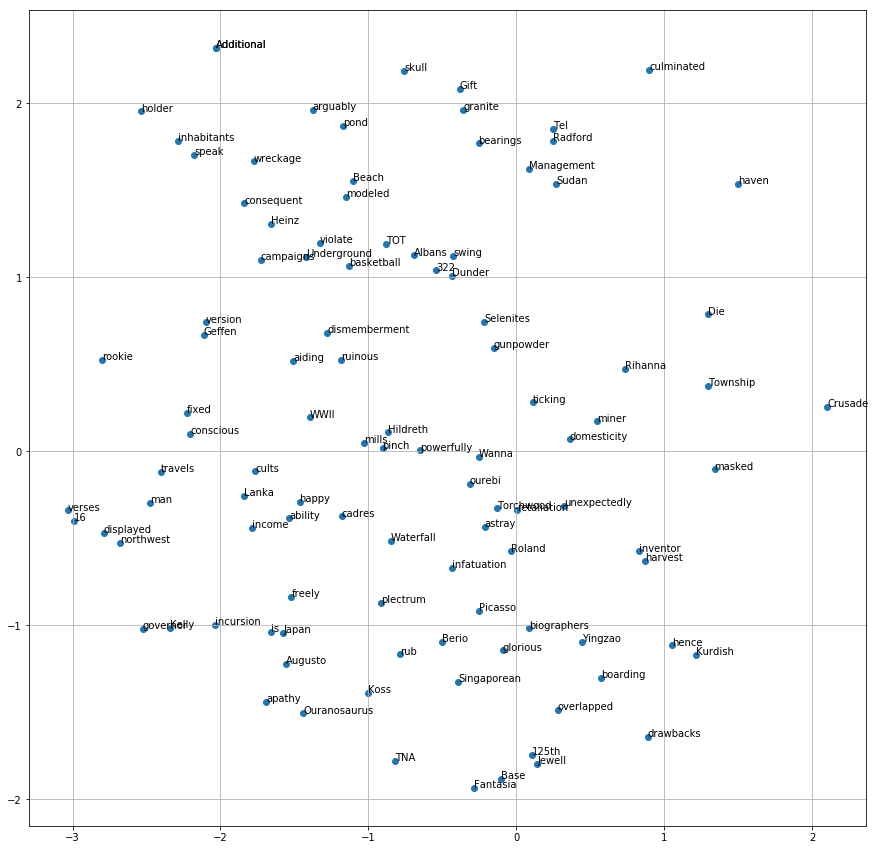

In [38]:
umap_plot(weight_matrix_lookup, total_idx_lookup, total_words_lookup)

## Projection

In [0]:
weight_matrix_projection = model_LSTM3.projection.weight

In [0]:
closest_dict_projection = {}
farthest_dict_projection = {}

lsts_projection = {}

for word in word_list:
    lst_projection = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix_projection.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix_projection[word_id],weight_matrix_projection[i])
            lst_projection.append((cos_sim.item(),i))
        lst_projection = sorted(lst_projection, key=lambda x: x[0], reverse=True)
        lsts_projection[word] = lst_projection
        closest_dict_projection[word] = [l[1] for l in lst_projection[:10]]
        farthest_dict_projection[word] = [l[1] for l in lst_projection[-10:]]

In [41]:
for word in word_list:
  print("the closest 10 for", word, ":", [wikitext_dict.get_token(i) for i in closest_dict_projection[word]])
  print("the farthest 10 for", word, ":",[wikitext_dict.get_token(i) for i in farthest_dict_projection[word]])
  print("highest cosine similarity:", lsts_projection[word][0][0], "word:", wikitext_dict.get_token(lsts_projection[word][0][1]))
  print("lowest cosine similarity:", lsts_projection[word][-1][0], "word:", wikitext_dict.get_token(lsts_projection[word][-1][1]))
  print("\n\n")

the closest 10 for Japan : ['Belgium', 'Canada', 'Germany', 'Asia', 'Switzerland', 'Australia', 'Europe', 'Sweden', 'India', 'Austria']
the farthest 10 for Japan : ['grave', 'dimer', 'informant', 'notched', 'victim', 'girl', 'trained', 'drugged', 'palisade', 'calf']
highest cosine similarity: 0.6824302673339844 word: Belgium
lowest cosine similarity: -0.4035908281803131 word: calf



the closest 10 for man : ['woman', 'person', 'girl', 'figure', 'human', 'warrior', 'baby', 'child', 'soldier', 'male']
the farthest 10 for man : ['Silverside', 'Avenue', 'Rico', '1K', 'demolished', 'Pauline', 'redesignated', 'dissipated', 'deposited', 'reconstructed']
highest cosine similarity: 0.6418400406837463 word: woman
lowest cosine similarity: -0.3179444670677185 word: reconstructed



the closest 10 for speak : ['accept', 'prove', 'learn', 'consider', 'agree', 'respond', 'tell', 'believe', 'meet', 'recognize']
the farthest 10 for speak : ['Main', 'Clair', 'Pipe', 'Cross', 'Byron', 'Huron', 'Lesser'

In [0]:
total_idx_projection = [closest_dict_projection[w] for w in word_list] + [farthest_dict_projection[w] for w in word_list]
import itertools
total_idx_projection = list(itertools.chain(*total_idx_projection))
total_words_projection = word_list + [wikitext_dict.get_token(i) for i in total_idx_projection]
total_idx_projection = [wikitext_dict.get_id(w) for w in word_list] + total_idx_projection

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


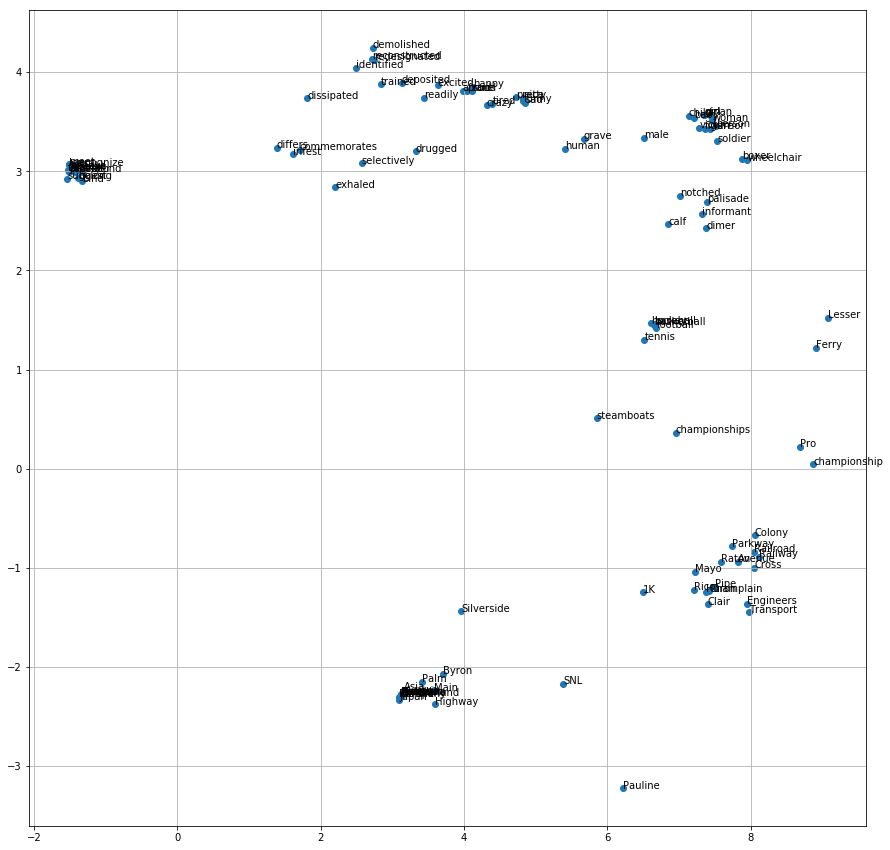

In [43]:
umap_plot(weight_matrix_projection, total_idx_projection, total_words_projection)

As we can see, the projection layer learned the word vectors better than the lookup layer so that we formed 5 clusters for our 5 words. On the other hand, the lookup layer plot does not have any clusters and all word vectors are just loosely plotted.

## Scoring

In [46]:
def get_prob_of_sequence(seq, token = "<eos>"):
    inp = wikitext_dict.encode_token_seq(seq.split(' '))
    target = inp[1:] + [wikitext_dict.get_id(token)]
    
    with torch.no_grad():
        model_LSTM3.eval()
        logits = model_LSTM3(torch.tensor([inp], dtype=torch.long).to(current_device))
    #print(logits.shape) 
    T = len(inp)
    ans = 0
    for i in range(T):
        tokid = target[i]
        prob_distr = torch.softmax(logits[0,i], dim=-1)
        prob_distr = prob_distr.cpu()
        ans += np.log(prob_distr[tokid]).item()
    return ans

seq = "<bos> i have a cat"
get_prob_of_sequence(seq)

-38.79034924507141

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [48]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)

100%|██████████| 9708/9708 [00:00<00:00, 32668.41it/s]


In [0]:
lst = []
for i,(k,v) in enumerate(wikitext_tensor_dataset["valid"]):
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][i][0] for j in w]
    seq = " ".join(seq)
    lst.append(get_prob_of_sequence(seq))
    
lst = [i for i in sorted(enumerate(lst), key=lambda x:x[1])]

In [50]:
lowest_idx = [l[0] for l in lst[:10]]
lowest_scores = [l[1] for l in lst[:10]]
highest_idx = [l[0] for l in lst[-100:]]
highest_scores = [l[1] for l in lst[-100:]]

for i in range(len(highest_idx)):
    idx = highest_idx[i]
    score = highest_scores[i]
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
    seq += ["eos"]
    print("Score:",score,":", " ".join(seq))

Score: -40.02970716962591 : <bos> unk> him up in the <unk> 's cage . eos
Score: -39.97768166474998 : <bos> Route 29 is a state highway in the U.S. state of New Jersey . eos
Score: -39.91252512927167 : <bos> ( <unk> ) with winds of 35 mph ( 55 km / h ) . eos
Score: -39.79137626872398 : <bos> The British did not attempt to take the fort again . eos
Score: -39.73978998279199 : <bos> unk> Christie took place on 12 January 2005 . eos
Score: -39.67537376657128 : <bos> Frank <unk> of GameSpot described the game as " one of the best < eos
Score: -39.547719698399305 : <bos> = = Mongolia – <unk> relations = = eos
Score: -39.49941062601283 : <bos> unk> and <unk> married on May 22 , 1911 . eos
Score: -39.45033620792674 : <bos> Mount <unk> is visible to the southwest of < eos
Score: -39.38281996548176 : <bos> = = Criticism of Germany 's stance = = eos
Score: -39.30467962141847 : <bos> unk> was in charge of the security force at < eos
Score: -39.28749337280169 : <bos> unk> " made available by the Ch

In [51]:
for i in range(len(lowest_idx)):
    idx = lowest_idx[i]
    score = lowest_scores[i]
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
    seq += ["eos"]
    print("Score:",score,":", " ".join(seq))

Score: -547.0097724173684 : <bos> To further justify its stance , the German government has also pointed to the long history of U.S. court cases involving Scientology , including the conviction of 11 top Scientologists in 1979 and 1980 for a conspiracy involving the infiltration of U.S. government agencies , <unk> and the theft of government documents , a 1994 U.S. Supreme Court finding that Scientology practices took place in a " <unk> environment " , and Scientology 's track record of pursuing its critics through malicious court cases and private investigators . eos
Score: -518.402462100843 : <bos> Two rival communist @-@ backed black nationalist groups initiated military campaigns to overthrow the government and introduce majority rule : the Chinese @-@ aligned Zimbabwe African National Union ( <unk> ) , mostly comprising <unk> , created the Zimbabwe African National Liberation Army ( ZANLA ) and adopted aspects of <unk> doctrine , while the <unk> @-@ dominated Zimbabwe African Peop

In [110]:
idx = highest_idx[-8]
score = highest_scores[-8]
seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
seq += ["<eos>"]
print("Score:",score,":", " ".join(seq))

new_seq = ['<bos>',"=",'=',"Return","to","the","United","States","=",'=']
new_score = get_prob_of_sequence(" ".join(new_seq))
print("Score:",new_score,":", " ".join(new_seq)," '<eos>'")

new_seq = ['<bos>',"=",'=',"Return","to","New","York","state","=",'=']
new_score = get_prob_of_sequence(" ".join(new_seq))
print("Score:",new_score,":", " ".join(new_seq)," '<eos>'")

Score: -24.72292283922434 : <bos> = = Return to New Zealand = = <eos>
Score: -21.512120231986046 : <bos> = = Return to the United States = =  '<eos>'
Score: -33.239677116274834 : <bos> = = Return to New York state = =  '<eos>'


"Return to the United States" improved because the sequence "the United States" is very common and thus increased the probability compared to "New Zealand". On the other hand, "New York state" should not be a common term in the corpus, since most people refer to NY state as simply "New York".

## Sampling

In [0]:
samples = []
for i in range(1000):
    start_index = torch.tensor([wikitext_dict.get_id("<bos>")])
    inp = start_index
    sample = ["<bos>"]
    model_LSTM3.eval()
    while inp.item() != wikitext_dict.get_id("<eos>"):
        out = model_LSTM3.lookup(inp.to(current_device))
        out.unsqueeze_(1)
        out = model_LSTM3.lstm(out)
        out = out[0]
        out = model_LSTM3.projection(out).to(current_device)
        p = torch.softmax(out[0,-1], dim=-1)
        #sample_id = torch.argmax(p)
        sample_id = torch.multinomial(p,1).item()
        sample_token = wikitext_dict.get_token(sample_id)
        sample.append(sample_token)
        inp = torch.tensor([wikitext_dict.get_id(sample_token)])
    samples.append(" ".join(sample))

In [0]:
import random
ids = random.sample(range(len(wikitext_tensor_dataset["valid"])), 1000)
samples_val = []
wikitext_tokenized_datasets["valid"][0]

for i in ids:
  sent = wikitext_tokenized_datasets["valid"][i]
  sent = [wikitext_dict.get_token(idx) for idx in sent]
  samples_val.append(" ".join(sent))

In [115]:
set_sample = set()
set_sample_val = set()
len_sample = []
len_sample_val = []

for i in range(len(samples)):
  sent = samples[i].split(" ")
  len_sample.append(len(sent))
  for word in sent:
    set_sample.add(word)
  
for i in range(len(samples_val)):
  sent = samples_val[i].split(" ")
  len_sample_val.append(len(sent))
  for word in sent:
    set_sample_val.add(word)

    
print("unique tokens in random samples:",len(set_sample))
print("average sentence length in random samples:",float(sum(len_sample)/len(len_sample)))
print("unique tokens in validation set:",len(set_sample_val))
print("average sentence length in validation set:",float(sum(len_sample_val)/len(len_sample_val)))

  

unique tokens in random samples: 6049
average sentence length in random samples: 24.318
unique tokens in validation set: 5025
average sentence length in validation set: 25.049


In [117]:
ids = random.sample(range(len(samples)), 3)
for i in ids:
  print(samples[i])

<bos> He was drawn from the q , which also was a national Internationale The wood Ottoman Medieval instruments <eos>
<bos> Brian The is the petty cloud as a vulgaris The Ramillies , , Sully was " In the very Paranthodon the United Kingdom <eos>
<bos> Two was <unk> <eos>


The samples look machine-generated because they are gramatically not correct. Also, they do not staty on topic, though some terms make logical sense.